# <center>Machine Learning Project</center>

** **
## <center>*02 - Feature Selection*</center>

** **

The members of the `team` are:
- Ana Farinha - 20211514
- Francisco Capontes - 20211692
- Sofia Gomes - 20240848
- Rui Lourenço - 2021639

## <span style="color:salmon"> Table of Contents </span>

<a class="anchor" id="top"></a>


1. [Filter Methods](#1-filter-methods)<br>  
    1.1 [Univariate Variables](#11-univariate-variables)<br>  
    1.2 [Correlation Indices](#12-correlation-indices)<br>    
    1.3 [Chi-Squared](#13-chi-squared)<br><br>     
2. [Wrapper Methods](#2-wrapper-methods)<br>    
    2.1 [Logistic Regression](#21-logistic-regression)<br>    
    2.2 [Support Vector Machine](#22-support-vector-machine)<br><br>      
3. [Embedded Methods](#3-embedded-methods)<br>     
    3.1 [LassoCV](#31-lassocv)<br>  



In [28]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Sklearn packages
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score

# Models
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

# embedded methods
from sklearn.linear_model import LassoCV
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.feature_selection import RFE

import warnings
warnings.filterwarnings('ignore')

from utils import *
from utils_feature_selection import *
from utils_dicts import *


# No train temos de input:
- Average Weekly Wage
- Age at Injury

- Based on the new Age at Injury calcular o Birth Year

*Input `Birth Year`*

In [2]:
# Import dataset
train_df = pd.read_csv('preprocessed_data/train_data.csv', index_col="Claim Identifier")
test_df =  pd.read_csv('preprocessed_data/test_data.csv', index_col="Claim Identifier")

In [3]:
missing_percentage = train_df.isna().sum() / len(train_df) * 100
for col, percent in missing_percentage.items():
    if not percent == 0:
        print(f"{col}: {percent:.2f}% missing values")

Age at Injury: 0.38% missing values
Average Weekly Wage: 63.43% missing values
Birth Year: 0.38% missing values


In [4]:
for col in train_df.columns:
    if col not in numerical_features and col not in categorical_features:
        print(f"'{col}',")

'Accident Date',
'Claim Injury Type Encoded',


In [5]:
X = train_df.drop(["Claim Injury Type Encoded"], axis = 1)
y = train_df["Claim Injury Type Encoded"]

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.25, stratify = y, shuffle = True)

# Input Age at Injury, Birth Year and Average Weekly Wage

In [11]:
to_impute = ["Age at Injury","Average Weekly Wage"]
imputation_value  = X_train[to_impute].median()
for col in to_impute:
        X_train[col].fillna(imputation_value[col], inplace=True)
        X_val[col].fillna(imputation_value[col], inplace=True)

In [12]:
# Ensure 'Accident Date' is in datetime format
X_train['Accident Date'] = pd.to_datetime(X_train['Accident Date'], errors='coerce')
X_val['Accident Date'] = pd.to_datetime(X_val['Accident Date'], errors='coerce')

# Now apply your logic
condition = X_train['Birth Year'].isna() & X_train['Age at Injury'].notna() & X_train['Accident Date'].notna()
X_train.loc[condition, 'Birth Year'] = X_train.loc[condition, 'Accident Date'].dt.year - X_train.loc[condition, 'Age at Injury']

# Filter the rows where 'Birth Year' is NaN, but 'Age at Injury' and 'Accident Date' are not NaN
condition = X_val['Birth Year'].isna() & X_val['Age at Injury'].notna() & X_val['Accident Date'].notna()
# Replace missing 'Birth Year' with the difference between 'Accident Date' year and 'Age at Injury'
X_val.loc[condition, 'Birth Year'] = X_val.loc[condition, 'Accident Date'].dt.year - X_val.loc[condition, 'Age at Injury']

In [13]:
X_train.drop('Accident Date',axis=1,inplace=True)
X_val.drop('Accident Date',axis=1,inplace=True)

# Creating New Features

*Average Weekly Wage*

Relative Wage Compared to Median Wage:<br>
Calculate whether the injured worker’s wage is above or below the median wage for the dataset, it's potentially reflecting job type or socioeconomic factors.

In [14]:
median_wage = X_train['Average Weekly Wage'].median()
X_train['Relative_Wage'] = np.where(X_train['Average Weekly Wage'] > median_wage, 1,0) #('Above Median', 'Below Median')
X_val['Relative_Wage'] = np.where(X_val['Average Weekly Wage'] > median_wage, 1,0) #('Above Median', 'Below Median')

*Financial Impact*

In [15]:
financial_impact(X_train)
financial_impact(X_val)

__Binning:__ Group ages into categories like "young" or "senior" if such categories might capture different risk profiles.<br>

In [16]:
age_bins = [0, 25, 40, 55, 70, 100]
age_labels = [0,1,2,3,4] #['Young', 'Mid-Age', 'Experienced', 'Senior', 'Elderly']
X_train['Age_Group'] = pd.cut(X_train['Age at Injury'], bins=age_bins, labels=age_labels)
X_val['Age_Group'] = pd.cut(X_val['Age at Injury'], bins=age_bins, labels=age_labels)

# Scaling

In [17]:
st = StandardScaler()
X_train[numerical_features] = st.fit_transform(X_train[numerical_features])
X_val[numerical_features] = st.transform(X_val[numerical_features])

# Feature Selection

In [18]:
n_features = len(X_train[numerical_features].columns)

*Univariate variables*

In [19]:
X_train[numerical_features].var().sort_values()

IME-4 Count                     1.000002
C-2 Date_Year                   1.000002
C-2 Date_Month                  1.000002
C-3 Date_Day                    1.000002
Number of Dependents            1.000002
Days_to_First_Hearing           1.000002
First Hearing Date_Year         1.000002
First Hearing Date_DayOfWeek    1.000002
Days_to_C2                      1.000002
Birth Year                      1.000002
C-3 Date_Month                  1.000002
C-3 Date_DayOfWeek              1.000002
First Hearing Date_Month        1.000002
Days_to_C3                      1.000002
Age at Injury                   1.000002
First Hearing Date_Day          1.000002
C-2 Date_Day                    1.000002
C-3 Date_Year                   1.000002
C-2 Date_DayOfWeek              1.000002
Average Weekly Wage             1.000002
dtype: float64

*Corr Matrix*

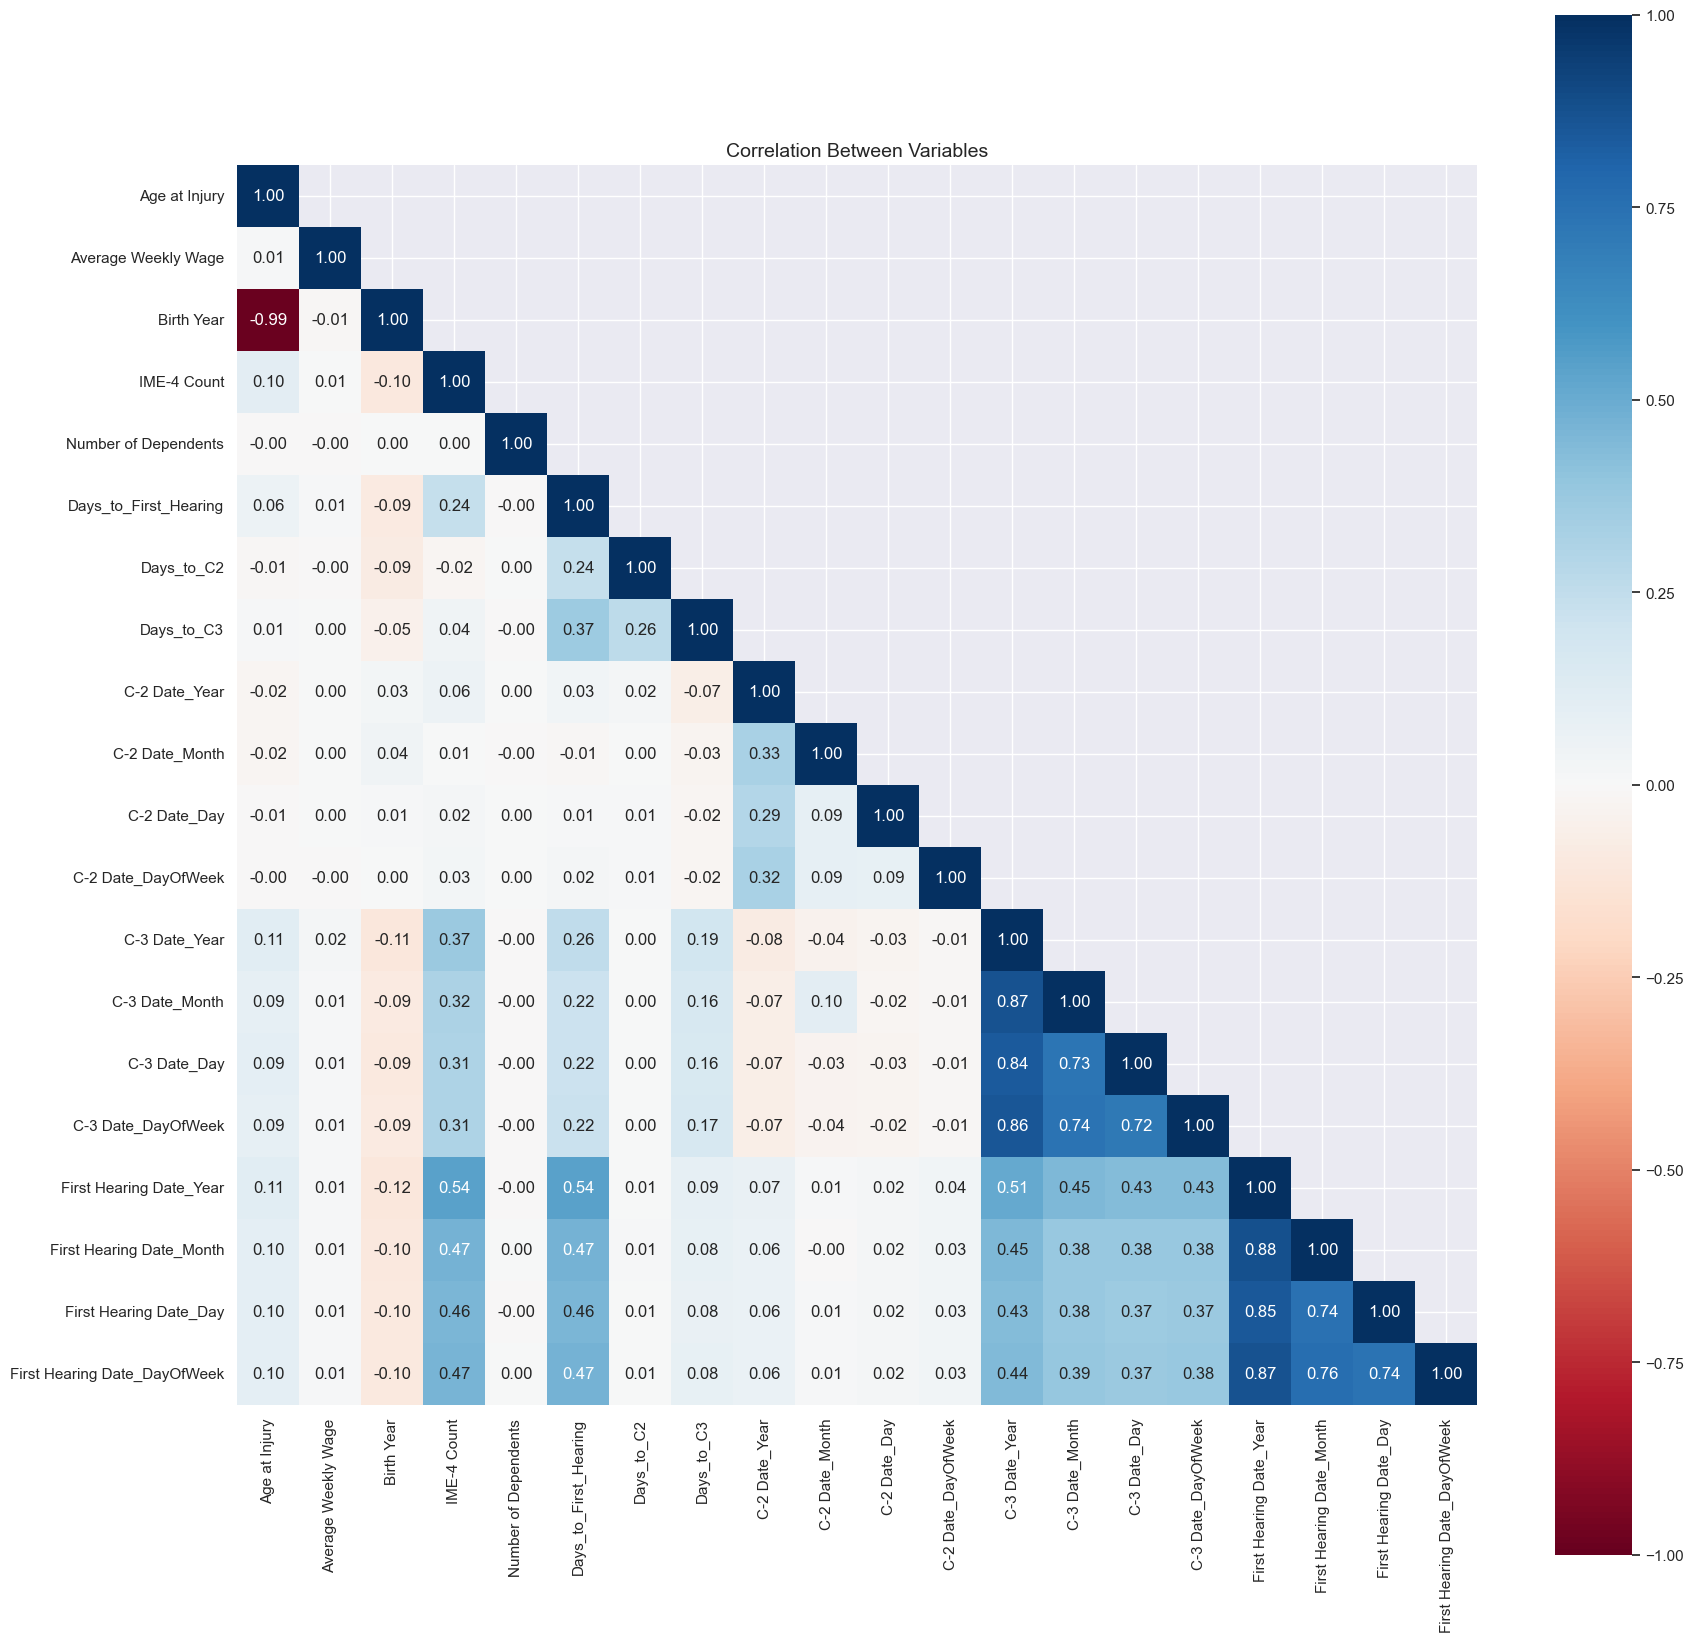

In [21]:
# initial correlation matrix with the respective values
corr_matrix = X_train[numerical_features].corr()

mask = np.tri(*corr_matrix.shape, k=0, dtype=bool)
# Keeps values where mask is True
corr_matrix = corr_matrix.where(mask)

# defines the figure size
fig, ax = plt.subplots(figsize=(20, 20))
# heatmap of the initial correlation matrix
l = sns.heatmap(corr_matrix, square=True, annot=True, fmt=".2f", vmax=1, vmin=-1, cmap='RdBu', ax=ax)
plt.title('Correlation Between Variables', size=14)
plt.show()

*XGBoosted RFE*

In [22]:
XGB = XGBClassifier(XGBClassifier(max_depth=5, learning_rate= 0.2, n_estimators= 200))

In [23]:
best_XGB = feature_selection_RFE(X_train[numerical_features],y_train,n_features,model=XGB)

In [24]:
best_XGB

['Age at Injury',
 'Average Weekly Wage',
 'Birth Year',
 'IME-4 Count',
 'Days_to_First_Hearing',
 'Days_to_C2',
 'Days_to_C3',
 'C-2 Date_Year',
 'C-2 Date_Month',
 'C-2 Date_Day',
 'C-2 Date_DayOfWeek',
 'C-3 Date_Year',
 'C-3 Date_Month',
 'C-3 Date_Day',
 'C-3 Date_DayOfWeek',
 'First Hearing Date_Year',
 'First Hearing Date_Month',
 'First Hearing Date_Day',
 'First Hearing Date_DayOfWeek']

*Gradient Boosted RFE*

In [31]:
LGB = lgb.LGBMClassifier(verbose=-1)

In [32]:
best_LGB =feature_selection_RFE(X_train[numerical_features],y_train,n_features,model=LGB)

In [33]:
best_LGB

['Age at Injury',
 'Average Weekly Wage',
 'Birth Year',
 'IME-4 Count',
 'Number of Dependents',
 'Days_to_First_Hearing',
 'Days_to_C2',
 'Days_to_C3',
 'C-2 Date_Year',
 'C-2 Date_Month',
 'C-2 Date_Day',
 'C-2 Date_DayOfWeek',
 'C-3 Date_Year',
 'C-3 Date_Month',
 'C-3 Date_Day',
 'First Hearing Date_Year',
 'First Hearing Date_Month',
 'First Hearing Date_Day']

*Decision Tree feature importance*

In [35]:
dt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, class_weight='balanced').fit(X_train[numerical_features],y_train)

In [40]:
feature_importances = dt.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train[numerical_features].columns,
    'Importance': feature_importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

In [41]:
feature_importance_df

,Feature,Importance
3,IME-4 Count,0.286450
5,Days_to_First_Hearing,0.188739
8,C-2 Date_Year,0.162147
1,Average Weekly Wage,0.147022
14,C-3 Date_Day,0.073808
19,First Hearing Date_DayOfWeek,0.058979
6,Days_to_C2,0.033419
0,Age at Injury,0.032909
11,C-2 Date_DayOfWeek,0.008946
9,C-2 Date_Month,0.005641


*Lasso*

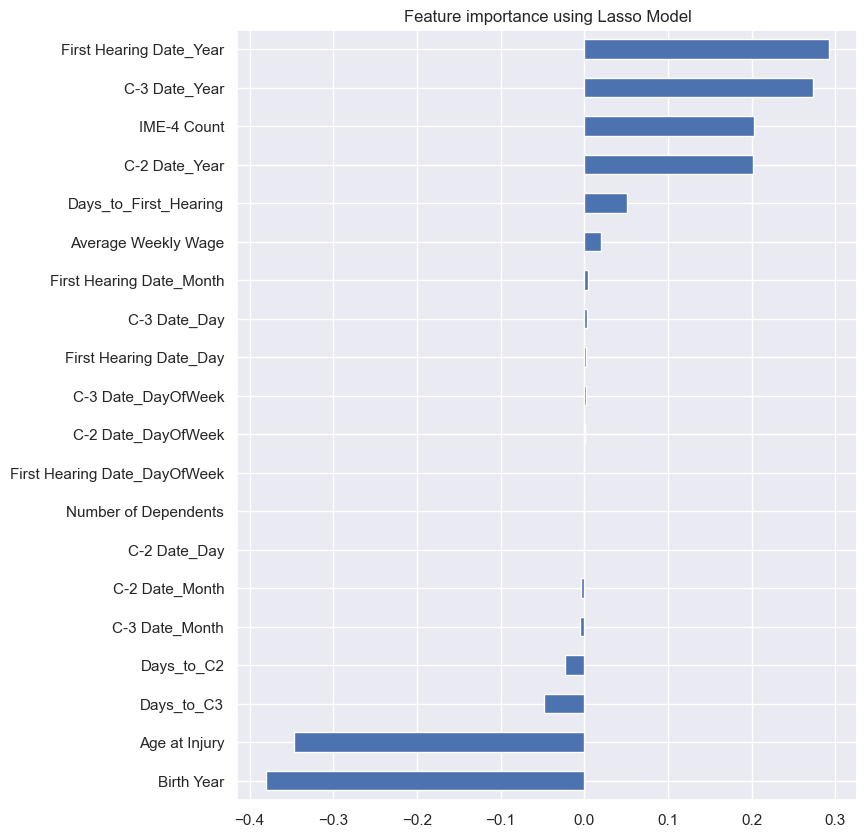

Age at Injury                  -0.346528
Average Weekly Wage             0.019972
Birth Year                     -0.380906
IME-4 Count                     0.203349
Number of Dependents           -0.000000
Days_to_First_Hearing           0.050982
Days_to_C2                     -0.022967
Days_to_C3                     -0.047860
C-2 Date_Year                   0.201270
C-2 Date_Month                 -0.004347
C-2 Date_Day                   -0.000822
C-2 Date_DayOfWeek              0.001275
C-3 Date_Year                   0.273356
C-3 Date_Month                 -0.005118
C-3 Date_Day                    0.002911
C-3 Date_DayOfWeek              0.001774
First Hearing Date_Year         0.292835
First Hearing Date_Month        0.004355
First Hearing Date_Day          0.002200
First Hearing Date_DayOfWeek   -0.000000
dtype: float64


In [42]:
feature_selection_Lasso(X_train[numerical_features],y_train)

*Chi-squared test*

In [43]:
for col in categorical_features:
    TestIndependence(X_train[col],y_train,col,alpha=0.05)

Enc County of Injury is IMPORTANT for Prediction
Enc District Name is IMPORTANT for Prediction
Enc Industry Code is IMPORTANT for Prediction
Medical Fee Region_I is IMPORTANT for Prediction
Medical Fee Region_II is IMPORTANT for Prediction
Medical Fee Region_III is IMPORTANT for Prediction
Medical Fee Region_IV is IMPORTANT for Prediction
Known Accident Date is NOT an important predictor. (Discard Known Accident Date from model)
Known Assembly Date is NOT an important predictor. (Discard Known Assembly Date from model)
Known C-2 Date is IMPORTANT for Prediction
Known C-3 Date is IMPORTANT for Prediction
Enc WCIO Cause of Injury Code is IMPORTANT for Prediction
Nature_Injury_Code_Hash_0 is IMPORTANT for Prediction
Nature_Injury_Code_Hash_1 is IMPORTANT for Prediction
Nature_Injury_Code_Hash_2 is IMPORTANT for Prediction
Nature_Injury_Code_Hash_3 is IMPORTANT for Prediction
Nature_Injury_Code_Hash_4 is IMPORTANT for Prediction
Nature_Injury_Code_Hash_5 is IMPORTANT for Prediction
Nature_

<hr>

### Numerical Data

| Predictor | Spearman | RFE XGB| RFE LGB | Lasso | Feature Importance DT | What to do? (One possible way to \"solve\") |
| --- | --- | --- | --- |--- |--- |---|
| Age at Injury | Keep | Keep | Keep | Discard | Discard | Try with and without |
| IME-4 Count | Keep | Keep | Keep | Include | Keep | Include in the model |
| Days_to_First_Hearing | Keep | Keep | Keep | Include | Keep | Include in the model |
| Days_to_C2 | Keep | Discard | Discard | Discard | Discard | Discard |
| Days_to_C3 | Keep | Discard | Discard | Discard | Discard | Discard |
| Average Weekly Wage | Keep | Keep | Keep | Include | Keep | Include in the model |
| Birth Year | Keep | Keep | Keep | Discard | Discard | Try with and without |
| Number of Dependents | Keep | Discard | Keep | Discard | Discard | Discard |
| C-2 Date_Year | Keep | Keep | Keep | Include | Keep | Include in the model |
| C-2 Date_Month | Keep | Discard | Discard | Discard | Discard | Discard |
| C-2 Date_Day | Keep | Discard | Discard | Discard | Discard | Discard |
| C-2 Date_DayOfWeek | Keep | Discard | Discard | Discard | Discard | Discard |
| C-3 Date_Year | Keep | Keep | Keep | Include | Keep | Include in the model |
| C-3 Date_Month | Keep | Discard | Discard | Discard | Discard | Discard |
| C-3 Date_Day | Keep | Keep | Discard | Include | Discard | Try with and without |
| First Hearing Date_Year | Keep | Keep | Keep | Include | Keep | Include in the model |
| First Hearing Date_Month | Keep | Keep | Keep | Discard | Discard | Try with and without |
| First Hearing Date_Day | Keep | Discard | Discard | Discard | Discard | Discard |
| First Hearing Date_DayOfWeek | Keep | Discard | Discard | Discard | Discard | Discard |

<hr>

### Categorical Data

| Predictor | Spearman | Chi-Square |
| --- | --- | --- |
| County of Injury | Keep | Keep |
| District Name | Keep | Keep |
| Industry Code | Keep | Keep |
| Medical Fee Region | Keep | Keep |
| Attorney/Representative | Keep | Keep |
| COVID-19 Indicator | Keep | Keep |
| Known C-2 Date | Keep | Keep |
| Known C-3 Date | Keep | Keep |
| Known First Hearing Date | Keep | Keep |
| Accident Date_Year | Keep | Keep |
| Accident Date_Month | Keep | Keep |
| Accident Date_Day | Keep | Keep |
| Gender_F | Keep | Keep |
| Gender_M | Keep | Keep |
| Weekend_Accident | Keep | Keep |

<hr>

In [44]:
#test_encoder = LabelEncoder()
#test_encoder.classes_ = target_decoder()